### Piston model:


# $P = \frac{2\cdot p_0}{\mathbf{\overrightarrow{tp}}} \cdot \frac{J_1(k\cdot r\cdot \textrm{sin}\theta)}{k\cdot r\cdot \textrm{sin}\theta}\cdot e^{(i\cdot k\cdot \mathbf{\overrightarrow{tp}})}$

complex pressure *$Pt(pz)$* at a point *$pz$* due to a flat circular piston emitter at point *$pt$*

### $P_t(p_z) = \frac{P_{ref}}{d(p_z, p_t)} \cdot \frac{2 \cdot J_1(k\cdot r\cdot \textrm{sin} \theta_{zt})}{k\cdot r\cdot \textrm{sin} \theta_{zt}}\cdot e^{i(\phi_t + k\cdot d(p_z,p_t))}$

$ P_{ref} $ is a constant that is defined by emitter amplitude, 

### $P_{ref} = A \cdot V_{pp} $

where $ A $ is the emitter output efficiency

and $ V_{pp} $ is the excitation signal peak-to-peak amplitude 

$ d(p_z, p_t) $ is the Euclidean distance between point $ p_z $ and the center of the emitter, $ p_t $ 

The directivity function for a emitter depends on the angle $\theta$ between the emitter normal and point $ p_z $ 

### $ D_f = \frac{2 \cdot J_1(k\cdot r\cdot \textrm{sin} \theta_{zt})} {k\cdot r\cdot \textrm{sin} \theta_{zt}} $

where $ J_1 $ is the Bessel function of the first kind, 

$ k=2\pi/\lambda $ is the wavenumber, 

$ r $ is the emitter radius, 

$ \theta_{zt} $ is the polar angle between points $p_z$ and $p_t$, 

$ \phi_t $ is the initial phase of the emitter

$ - \, \textit{credit: Francisco}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from holograPy_functions import points_vector_builder, PM_propagator_function_builder, coords_shape

In [2]:
# ---> physics params <---
c0 = 343.  # [m/s]
v = 40000  # [Hz]
lam = c0 / v  # [m]
k = 2 * np.pi / lam  # [rads/m]
resolution = 4

# ---> location of the focus <---
focal_point = (0, 0, 10*lam)

# ---> transducer plane calculation <---
m_PAT, n_PAT = 8, 8
dx_PAT = 10.5/1000 # [m]
PAT_centrepoint = (0, 0, 0)
PAT_sidelengths = [((m_PAT/2)*dx_PAT, (m_PAT/2)*dx_PAT), ((n_PAT/2)*dx_PAT, (n_PAT/2)*dx_PAT), (0, 0)]
PAT_points = points_vector_builder(PAT_centrepoint, PAT_sidelengths, dx_PAT)
PAT_normal = np.array([0, 0, 1])

# ----> xz_eval plane calculation <----
dx_xz_eval = (lam/2)/resolution
xz_eval_centrepoint = focal_point
xz_eval_sidelengths = [(5*lam, 5*lam), (0, 0), (focal_point[2], focal_point[2])] # [(-x, +x), (-y, +y), (-z, +z)]
xz_eval_points = points_vector_builder(xz_eval_centrepoint, xz_eval_sidelengths, dx_xz_eval)

# ----> xy_eval plane calculation <----
dx_xy_eval = (lam/2)/resolution
xy_eval_centrepoint = focal_point
xy_eval_sidelengths = [(5*lam, 5*lam), (5*lam, 5*lam), (0, 0)] # [(-x, +x), (-y, +y), (-z, +z)]
xy_eval_points = points_vector_builder(xy_eval_centrepoint, xy_eval_sidelengths, dx_xy_eval)

In [3]:
print(PAT_points.shape)

(64, 3)


In [4]:
# ----> focussing transducer complex pressure with backprop <----
A_magnitude = 1
H_focus_PAT = PM_propagator_function_builder([focal_point], PAT_points, PAT_normal, k)
P_focus = A_magnitude*np.ones(1)*np.exp(1j*np.ones(1))
phasemap = np.angle(np.dot(P_focus.reshape(-1, 1), np.conj(H_focus_PAT.reshape(1, -1))))
phasemap = np.mod(phasemap, 2*np.pi) - np.pi

In [5]:
# ----> propagating <----
Pt = A_magnitude*np.ones((m_PAT*n_PAT))*np.exp(1j*phasemap)

print("xz", xz_eval_points.shape)
print("PAT", PAT_points.shape)

# ----> xz eval plane propagation <----
H_xz = PM_propagator_function_builder(xz_eval_points, PAT_points, PAT_normal, k)

print("H_xz", H_xz.shape)

H_xz = H_xz.reshape(m_PAT*n_PAT, -1)
Pf_xz = np.dot(Pt, H_xz).reshape(coords_shape(xz_eval_sidelengths, resolution, lam))

# ----> xy eval plane propagation <----
H_xy = PM_propagator_function_builder(xy_eval_points, PAT_points, PAT_normal, k)
H_xy = H_xy.reshape(m_PAT*n_PAT, -1)
Pf_xy = np.dot(Pt, H_xy).reshape(coords_shape(xy_eval_sidelengths, resolution, lam))

xz (12800, 3)
PAT (64, 3)
H_xz (819200,)


In [6]:
print(H_xz.shape)

(64, 12800)


In [7]:
# mask = np.zeros((16,16), dtype=complex)
# mask[4:12, 4:12] = 1

# plt.imshow(abs(mask))
# plt.show()

# plt.imshow(np.angle(mask))
# plt.show()

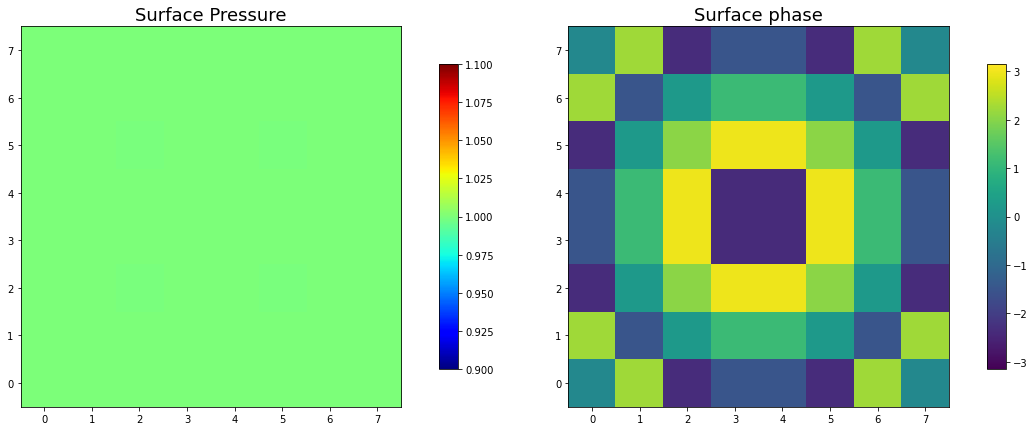

In [9]:
# ----> plotting <----
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Pt = mask.reshape(m_PAT*n_PAT)*Pt

im1 = ax1.imshow(abs(Pt).reshape(m_PAT, n_PAT), plt.get_cmap("jet"), origin="lower")
cax = ax1.inset_axes([1.1, 0.1, 0.05, 0.8]) # [x0, y0, width, height]
ax1.set_title("Surface Pressure", fontsize=18)
plt.colorbar(im1, cax=cax)

im2 = ax2.imshow(np.angle(Pt).reshape(m_PAT, n_PAT), origin="lower",vmin=-np.pi, vmax=np.pi)
cax = ax2.inset_axes([1.1, 0.1, 0.05, 0.8]) # [x0, y0, width, height]
ax2.set_title("Surface phase", fontsize=18)
plt.colorbar(im2, cax=cax)

plt.show()

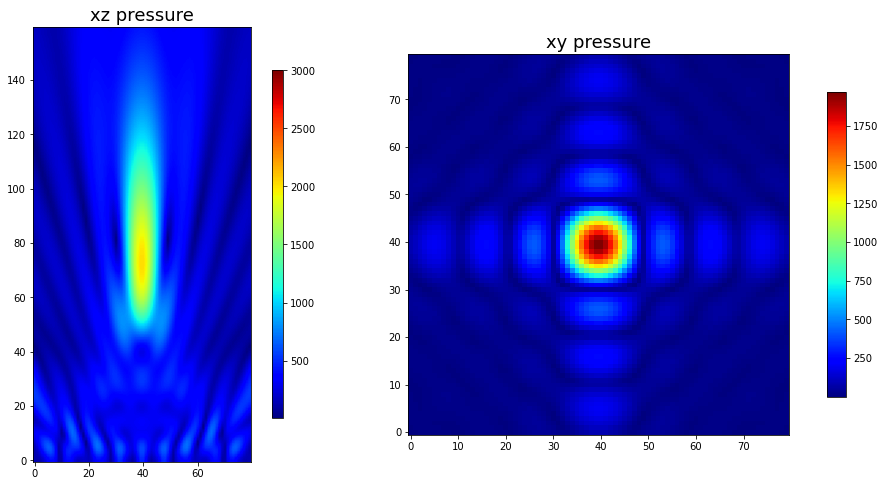

In [ ]:
# Pf_xz = np.dot(Pt, H_xz).reshape(coords_shape(xz_eval_sidelengths, resolution, lam))
# Pf_xy = np.dot(Pt, H_xy).reshape(coords_shape(xy_eval_sidelengths, resolution, lam))

# ----> plotting <----
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

im1 = ax1.imshow(abs(Pf_xz), plt.get_cmap("jet"), origin="lower", vmax=3000)
cax = ax1.inset_axes([1.1, 0.1, 0.05, 0.8]) # [x0, y0, width, height]
ax1.set_title("xz pressure", fontsize=18, color = "white")
plt.colorbar(im1, cax=cax)

im2 = ax2.imshow(abs(Pf_xy), plt.get_cmap("jet"), origin="lower")
cax = ax2.inset_axes([1.1, 0.1, 0.05, 0.8]) # [x0, y0, width, height]
ax2.set_title("xy pressure", fontsize=18, color = "white")
plt.colorbar(im2, cax=cax)

plt.show()

In [11]:
phasemap_save_flag = True

fp_coord_string =  "x"+str(round(focal_point[0], 4))+"_y"+str(round(focal_point[1], 4))+"_z"+str(round(focal_point[2], 4))

if phasemap_save_flag:
    filename = "p_focus_m"+str(m_PAT)+"_n"+str(n_PAT)+"_"+fp_coord_string+".csv"
    print(filename)
    np.savetxt(filename, np.angle(Pt).T)

p_focus_m8_n8_x0_y0_z0.0857.csv


In [12]:
amp_save_flag = True

fp_coord_string =  "x"+str(round(focal_point[0], 4))+"_y"+str(round(focal_point[1], 4))+"_z"+str(round(focal_point[2], 4))

if amp_save_flag:
    filename = "a_focus_m"+str(m_PAT)+"_n"+str(n_PAT)+"_"+fp_coord_string+".csv"
    print(filename)
    np.savetxt(filename, abs(Pt).T)

a_focus_m8_n8_x0_y0_z0.0857.csv
